In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [3]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./measurements')
meas_dict = {}
for fname in os.listdir(meas_dir):
    with open(os.path.join(meas_dir, fname)) as file:
        meas = [[float(el) for el in row.rstrip('\t').split(',')]
                for row in file.readlines()[12:]]
        meas_name = os.fsdecode(fname).removesuffix('.csv')
        meas_dict[meas_name] = np.array(meas).T

In [4]:
def crop(arr, α, β):
    N = len(arr)
    return arr[int(α*N):int(β*N)]

def U_ansatz(t, U_0, τ):
    return U_0 * np.exp(-t/τ)

In [5]:
# General measurements
ε_0 = 8.854e-12
g = 9.80665
R, ΔR = 5e9, 0.1e9
S, ΔS = np.pi * (38e-3/2)**2, np.pi * 2*(38e-3/2) * 0.2e-3/2
b, Δb = 6.5e-3, 0.2e-3
m_1, m_2, m_3, Δm = 196e-3, 503e-3, 1007e-3, 1

In [6]:
1e4 * S, 1e4 * ΔS

(11.341149479459153, 0.11938052083641214)

In [7]:
def process_meas(meas_name, α, β):
    meas = meas_dict[meas_name]
    t_raw, U_raw = meas[:,:-100:100]
    U_base = np.mean(crop(U_raw, 0, α))
    σU_base = np.std(crop(U_raw, 0, α))
    U = U_raw - U_base
    t = t_raw - t_raw[np.argmax(-U_raw)]

    # Plot.
    fig, ax = plt.subplots(1, 1, figsize=[6, 4])

    # Plot measurements.
    ax.plot(crop(t, 0, α), crop(U, 0, α), color='seagreen', alpha=0.5, label='meritev')
    ax.plot(crop(t, α, β), crop(U, α, β), color='lightsalmon', label='izključeno')
    ax.plot(crop(t, β, 1), crop(U, β, 1), color='seagreen', alpha=0.5)

    # Fit and calculate C and ε.
    par, cov = curve_fit(U_ansatz, crop(t, β, 1), crop(-U, β, 1), absolute_sigma=True)
    U_0, τ = par
    σU_0, στ = np.sqrt(np.diag(cov))
    ΔU_0 = np.sqrt(σU_0**2 + σU_base**2)
    C = τ / R
    ΔC = np.sqrt(
        (1/R * στ)**2 +
        (-τ/R**2 * ΔR)**2
    )
    ε = C*b / (ε_0*S)
    Δε = np.sqrt(
        (1*b / (ε_0*S) * ΔC)**2 +
        (C*1 / (ε_0*S) * Δb)**2 +
        (-C*b / (ε_0 * S**2) * ΔS)**2
    )

    # Plot fitted.
    t_lin = np.linspace(np.min(crop(t, β, 1)) - 1, np.max(crop(t, β, 1)) + 1)
    ax.plot(t_lin, -U_ansatz(t_lin, U_0, τ), color='black', label='fit z repom')

    # Labels and style.
    is_rise = meas_name.split('-')[0] == 'rise'
    title_part = 'Razbremenitev' if is_rise else 'Obremenitev'
    i_to_m_dict = {3: m_1, 4: m_2, 5: m_3}
    m = i_to_m_dict[int(meas_name.split('-')[1])]
    ax.set_title(f"{title_part} s ${m}\,\mathrm{{g}}$ utežjo")
    ax.set_xlabel(r'$t\,[\mathrm{s}]$')
    ax.set_ylabel(r"$\Delta U\,[\mathrm{V}]$")
    ax.grid(linestyle=':')
    ax.legend(loc='lower right')
    ax.margins(x=0.08, y=0.08)
    fig.savefig(f'{meas_name.split("-")[0]}-{1000*m:.0f}.pdf')
    return (m if is_rise else -m), U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε

196 & 0.27 & 0.04 & 10.3 & 2.4 & 2.1 & 0.5 & 1329 & 315 \\
503 & 0.72 & 0.05 & 8.0 & 0.8 & 1.6 & 0.2 & 1038 & 113 \\
1007 & 1.28 & 0.05 & 8.8 & 0.5 & 1.8 & 0.1 & 1138 & 76 \\
-196 & -0.31 & 0.05 & 7.3 & 1.4 & 1.5 & 0.3 & 941 & 186 \\
-503 & -0.89 & 0.08 & 7.8 & 0.6 & 1.6 & 0.1 & 1011 & 93 \\
-1007 & -1.50 & 0.05 & 8.2 & 0.3 & 1.6 & 0.1 & 1067 & 57 \\


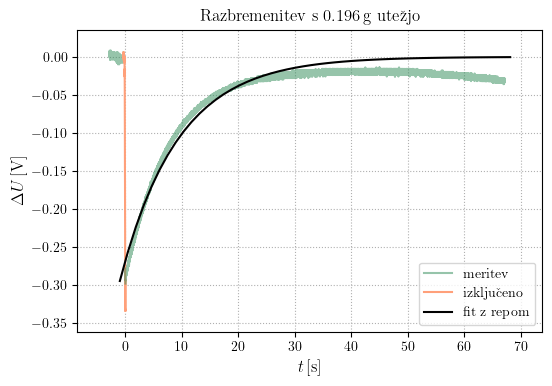

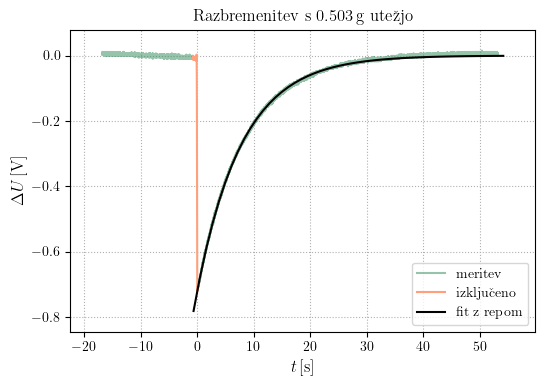

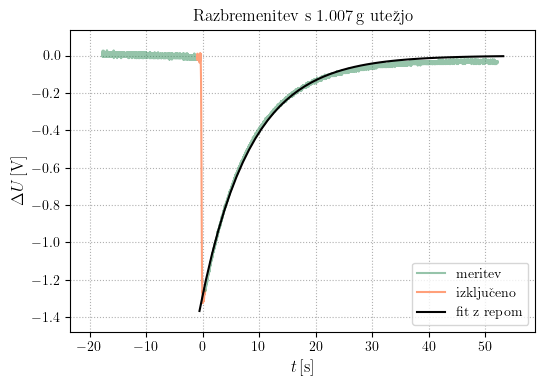

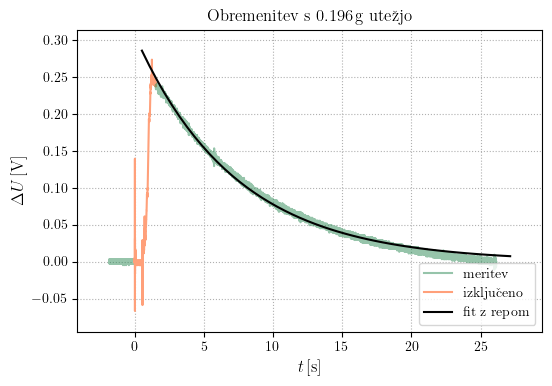

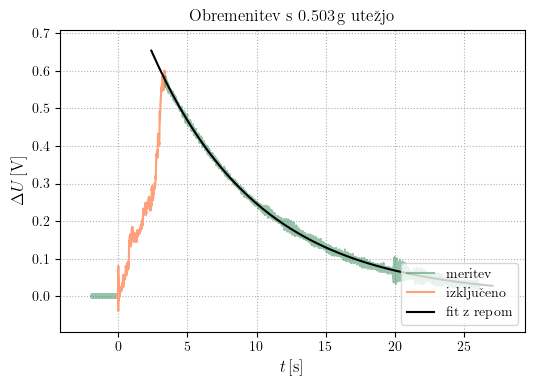

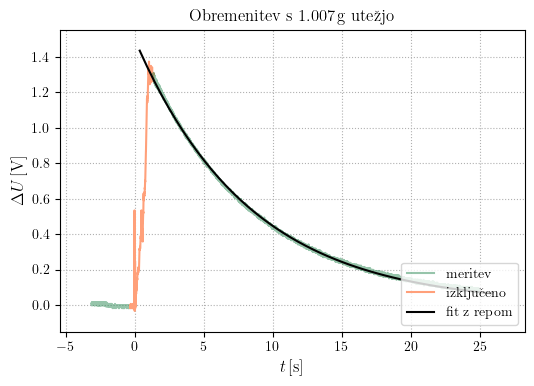

In [8]:
calc_arr = []
for meas_name, α, β in [('rise-3', 0.036, 0.041),
                        ('rise-4', 0.23, 0.245),
                        ('rise-5', 0.24, 0.26),
                        ('fall-3-repeat', 0.065, 0.12),
                        ('fall-4', 0.065, 0.19),
                        ('fall-5', 0.1, 0.16)]:
    calc = process_meas(meas_name, α, β)
    calc_arr.append(calc)
    m_sgn, U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε = calc
    print(f'{1000*m_sgn:.0f} & {U_0:.2f} & {ΔU_0:.2f} & {τ:.1f} & {στ:.1f} & {1e9 * C:.1f} & {1e9 * ΔC:.1f} & {ε:.0f} & {Δε:.0f} \\\\')

(1.6796704727240046,
 0.19054351082254903,
 0.2442364421910032,
 0.02908473005087585)

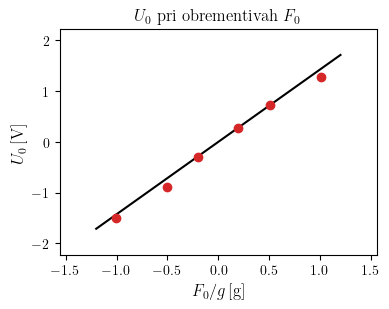

In [9]:
m_sgn, U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε = np.array(calc_arr).T
par, cov = np.polyfit(m_sgn, U_0, 1, cov=True)
k, c = par
σk = np.sqrt(cov[0,0])
C_mean, σC_mean = np.mean(C), np.std(C)
d = k*C_mean/g
Δd = np.sqrt(
    (1*C_mean/g * σk)**2 +
    (k*1/g * σC_mean)**2
)

fig, ax = plt.subplots(1, 1, figsize=[4, 3.2])

ax.scatter(m_sgn, U_0, color='tab:red')
m_lin = np.linspace(-1.2, 1.2)
ax.plot(m_lin, k*m_lin, color='black', zorder=-1)

ax.set_title(r'$U_0$ pri obrementivah $F_0$')
ax.set_xlabel(r'$F_0/g\,[\mathrm{g}]$')
ax.set_ylabel(r"$U_0\,[\mathrm{V}]$")
ax.margins(x=0.15, y=0.15)
fig.tight_layout()
fig.savefig('U_0-by-m.pdf')
1e9 * C_mean, 1e9 * σC_mean, 1e9 * d, 1e9 * Δd

In [10]:
ε_mean = np.mean(ε)
σε_mean = np.std(ε)
ε_mean, σε_mean

(1087.2786297173654, 123.34198327169078)